# Assignment 6 - Question 1  
**Group 7**  
Alejandro Akifarry - 301-195-788  
Sirada Thoungvitayasutee - 301-292-632  

---

In [1]:
# newer numpy versions than this gave us errors
!pip install numpy==1.26.0

## Imports

In [23]:
import gym
import tensorflow as tf
import numpy as np

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

import matplotlib.pyplot as plt
import matplotlib.animation
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('animation', html='jshtml')

---

## Environment Setup

In [24]:
env = gym.make('LunarLander-v2', render_mode='rgb_array')

In [25]:
state_size = env.observation_space.shape[0] # 8
action_size = env.action_space.n # 4

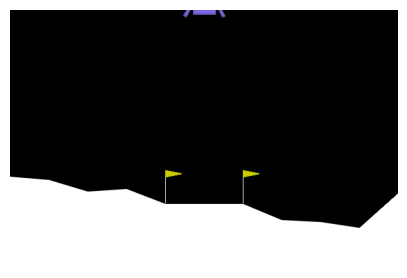

In [26]:
def plot_environment(env, figsize=(5, 4)):
    plt.figure(figsize=figsize)
    img = env.render()
    plt.imshow(img)
    plt.axis("off")
    return img

env.reset(seed=42)
plot_environment(env)
plt.show()

---

## 1. Create a simple DQN epsilon policy network with 4 output neurons (one per possible action).  [Hint: DQN Agents use Epsilon greedy policy]

In [27]:
def build_dqn(state_size, action_size):
    model = Sequential()
    model.add(Dense(64, input_dim=state_size, activation='elu'))
    model.add(Dense(64, activation='elu'))
    model.add(Dense(action_size, activation='linear'))
    model.compile(optimizer='adam', loss='mse')
    return model

dqn_model = build_dqn(state_size, action_size)
dqn_model.summary()

C:\ProgramData\Anaconda3\envs\ale1\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 64)                  │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,996 (19.52 KB)

 Trainable params: 4,996 (19.52 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(action_size)  # random action
    else:
        Q_values = dqn_model.predict(state[np.newaxis], verbose=0)[0]
        return Q_values.argmax()  # optimal action according to the DQN

---

## 2. Discuss the rationale of the activation functions & the loss function used in the network.

### **Response in analysis report.**

---

## 3. Define the hyperparameters: (i) the number of iterations, (ii) the number of episodes, (iii) the maximum number of steps, and (iv) the discount factor  at each step.

In [29]:
num_iterations = 100000
num_episodes = 1200
max_steps = 500
discount_factor = 0.99

---

## 4. Train the agent on the LunarLander-v2 environment for a sufficient number of episodes to achieve a satisfactory level of performance.

In [30]:
# Code block to show animation (from lab exercise)
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40, title=None):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    if title:
        plt.title(title)
    anim = matplotlib.animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

def show_one_episode(policy, n_max_steps=200, seed=42, title=None):
    frames = []
    env = gym.make('LunarLander-v2', render_mode='rgb_array')
    np.random.seed(seed)
    obs, info = env.reset(seed=seed)
    for step in range(n_max_steps):
        frames.append(env.render())
        action = policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        if done or truncated:
            break
    env.close()
    return plot_animation(frames, title=title)

In [10]:
# Before training
show_one_episode(epsilon_greedy_policy, 2000, 42, title='Before training')

C:\ProgramData\Anaconda3\envs\ale1\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [31]:
from collections import deque

# contains (obs, action, reward, next_obs, done)
replay_buffer = deque(maxlen=100000)

In [32]:
# taken from lab exercise
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    return [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(6)
    ]  # [states, actions, rewards, next_states, dones, truncateds]

In [33]:
# taken from lab exercise
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, truncated, info = env.step(action)
    replay_buffer.append((state, action, reward, next_state, done, truncated))
    return next_state, reward, done, truncated, info

In [34]:
batch_size = 32

# Training step using model.fit
def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences
    next_Q_values = dqn_model.predict(next_states, verbose=0)
    max_next_Q_values = next_Q_values.max(axis=1)
    runs = 1.0 - (dones | truncateds)  # episode is not done or truncated
    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    
    # Mask to update only the Q-values for the taken actions
    # 1 = needs updating
    # 0 = keep same
    mask = tf.one_hot(actions, action_size)
    
    # Predict current Q-values for states
    current_Q_values = dqn_model.predict(states, verbose=0)
    
    # Update the Q-values ONLY for the actions taken
    current_Q_values = current_Q_values * (1 - mask) + target_Q_values * mask
    
    # Train the model using model.fit
    dqn_model.fit(states, current_Q_values, batch_size=batch_size, verbose=0)

In [15]:
rewards = [] # cumulative reward per episode
steps_list = []
best_score = 0

# Start training
for episode in range(num_episodes):
    obs, info = env.reset()
    total_reward = 0
    for step in range(max_steps):
        epsilon = max(1 - episode / num_episodes, 0.01)  # Decaying epsilon
        obs, reward, done, truncated, info = play_one_step(env, obs, epsilon)
        total_reward += reward
        if done or truncated:
            break

    # Extra code – displays debug info, stores data for the next figure, and
    # keeps track of the best model weights so far
    print(f"\rEpisode: {episode + 1}, Steps: {step + 1}, eps: {epsilon:.3f}",
          end="")

    # Collect data to examine learning progress
    rewards.append(total_reward)
    steps_list.append(step)
    
    if step >= best_score:
        best_weights = dqn_model.get_weights()
        best_score = step

    if episode > 50: # ensure we have enough experiences before training
        training_step(batch_size)

# Restore the best model weights
dqn_model.set_weights(best_weights)

C:\ProgramData\Anaconda3\envs\ale1\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode: 1200, Steps: 324, eps: 0.010

In [19]:
show_one_episode(epsilon_greedy_policy, 2000, 42, title='After training')

---

## 5. Analyze the agent's learning progress by plotting relevant performance metrics (e.g., cumulative rewards, episode length) over time.

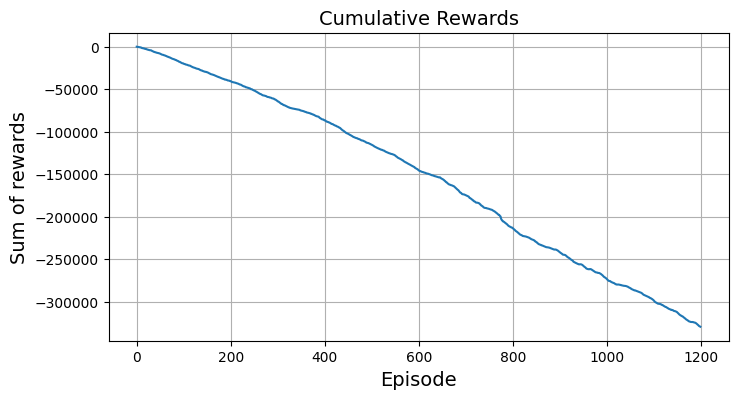

In [35]:
cumulative_rewards = []
current_reward = rewards[0]
cumulative_rewards.append(current_reward)

for i in range(1, len(rewards)):
    current_reward = current_reward + rewards[i]
    cumulative_rewards.append(current_reward)

plt.figure(figsize=(8, 4))
plt.plot(cumulative_rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.title("Cumulative Rewards")
plt.grid(True)
plt.show()

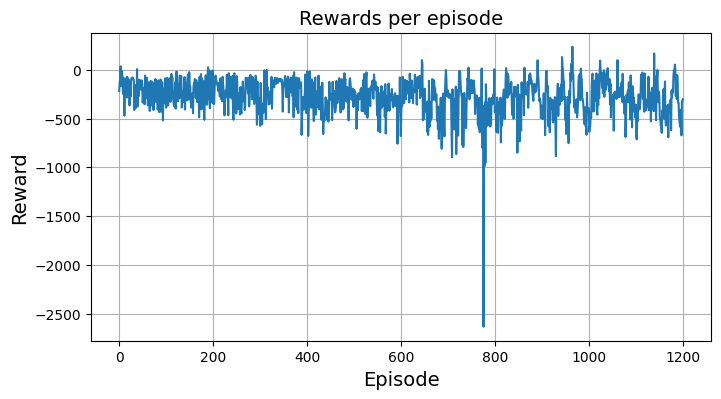

In [36]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Reward", fontsize=14)
plt.title("Rewards per episode")
plt.grid(True)
plt.show()

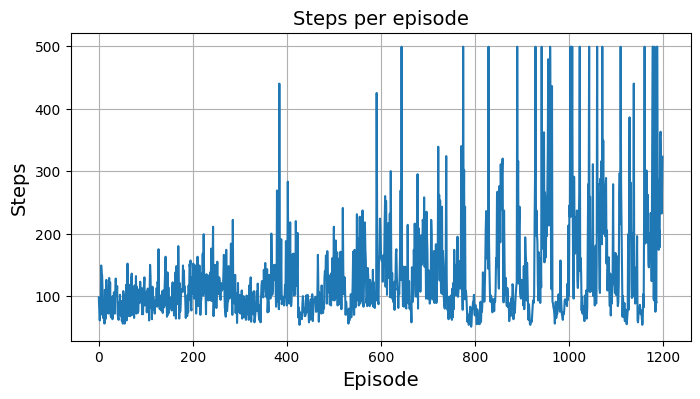

In [37]:
plt.figure(figsize=(8, 4))
plt.plot(steps_list)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Steps", fontsize=14)
plt.title("Steps per episode")
plt.grid(True)
plt.show()

---

## 6. Discuss the challenges faced during training and potential strategies for further improving the agent's performance.

### **Response in analysis report.**

---